In [1]:
%pip install geopy --quiet

Note: you may need to restart the kernel to use updated packages.


In [1]:
from geopy.geocoders import Nominatim

def geocode_location(address):
    """
    Given a string like "Dhanmondi, Dhaka", return (lat, lon) in decimal degrees.
    We append ", Bangladesh" so Nominatim knows to look there.
    Returns a tuple (lat, lon) or None if geocoding fails.
    """
    geolocator = Nominatim(user_agent="watergate_app")
    full_address = f"{address}, Bangladesh"
    location = geolocator.geocode(full_address)
    if location is None:
        return None
    return location.latitude, location.longitude


In [2]:
# Test the geocode function
test_address = "Feni River, Feni"
result = geocode_location(test_address)
if result:
    lat, lon = result
    print(f"Geocoded '{test_address}' → lat={lat:.6f}, lon={lon:.6f}")
else:
    print(f"❌ Could not geocode '{test_address}'. Try a different address.")


Geocoded 'Feni River, Feni' → lat=22.831263, lon=91.336773


In [3]:
import numpy as np

def get_bbox(lat, lon):
    """
    Given a (latitude, longitude) in degrees, return a bounding box
    of around 100 km^2 around that point as (west, south, east, north) in degrees.
    """
    # 1) Convert 900 m into degrees at this latitude
    meters_per_deg_lat = 111_000.0
    meters_per_deg_lon = 111_000.0 * np.cos(np.deg2rad(lat))
    delta_deg_lat = 10000.0 / meters_per_deg_lat
    delta_deg_lon = 10000.0 / meters_per_deg_lon

    # 2) Half‐width in each direction
    half_lat = delta_deg_lat / 2.0
    half_lon = delta_deg_lon / 2.0

    # 3) Compute box
    west = lon - half_lon
    east = lon + half_lon
    south = lat - half_lat
    north = lat + half_lat

    return west, south, east, north


lat, lon = result  # reuse from Step 1
w, s, e, n = get_bbox(lat, lon)
print(f"bounding box for ({lat:.6f}, {lon:.6f}):")
print(f"  West = {w:.6f}, South = {s:.6f}")
print(f"  East = {e:.6f}, North = {n:.6f}")
print(f"  Approx. size: {(e-w)*111000:.0f} m × {(n-s)*111000:.0f} m ≈ {(e-w)*111000 * ((n-s)*111000)/1e6:.3f} km²")


bounding box for (22.831263, 91.336773):
  West = 91.287899, South = 22.786218
  East = 91.385648, North = 22.876308
  Approx. size: 10850 m × 10000 m ≈ 108.501 km²


⬇️ Requesting DEM from OpenTopography for box:
   W=91.287899, S=22.786218, E=91.385648, N=22.876308
✅ DEM saved to: dem_user.tif


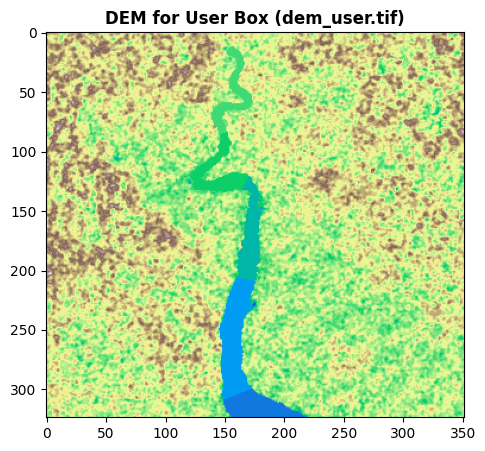

<Figure size 640x480 with 0 Axes>

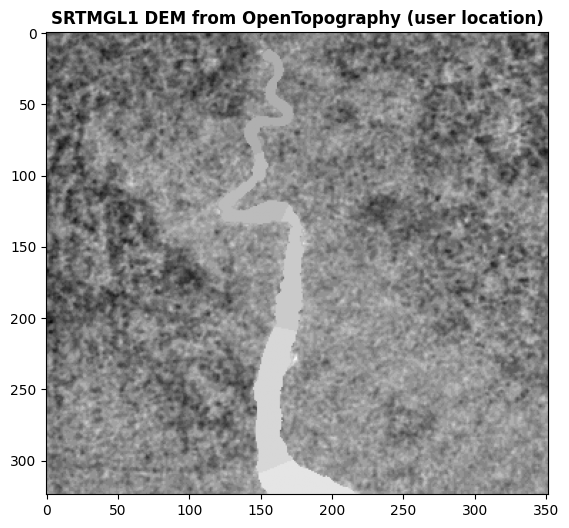

<Axes: title={'center': 'SRTMGL1 DEM from OpenTopography (user location)'}>

In [4]:
import requests
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt


API_KEY = "81ac76541b208f2e3a9a4c24e7bfc6bc"  # <-- our API key, please keep it secret!

def download_dem_opentopo(west, south, east, north, out_tif="dem_user.tif"):
    """
    Download a SRTMGL1 DEM from OpenTopography for the bounding box
    (west, south, east, north) in degrees, save to out_tif.
    """
    # 1) Build the URL
    url = (
          "https://portal.opentopography.org/API/globaldem?"
    f"demtype=SRTMGL1&south={south}&north={north}&west={west}&east={east}"
    f"&outputFormat=GTiff&API_Key={API_KEY}"
    )
    print(f"⬇️ Requesting DEM from OpenTopography for box:\n   W={west:.6f}, S={south:.6f}, E={east:.6f}, N={north:.6f}")
    r = requests.get(url)
    if r.status_code != 200:
        raise RuntimeError(f"Failed to download DEM (HTTP {r.status_code}): {r.text}")

    # 2) Save the content to a GeoTIFF
    with open(out_tif, "wb") as f:
        f.write(r.content)
    print("✅ DEM saved to:", out_tif)

    # 3) Plot the DEM to verify
    with rasterio.open(out_tif) as src:
        arr = src.read(1)
        plt.figure(figsize=(6, 5))
        show(arr, cmap="terrain", title=f"DEM for User Box ({out_tif})")
        plt.tight_layout()
        plt.show()

    return out_tif

# Test it immediately:
west, south, east, north = get_bbox(lat, lon)
dem_path = download_dem_opentopo(west, south, east, north, out_tif="dem_user.tif") # we save out_tif in dem_use.tif file


with rasterio.open("dem_user.tif") as src:
    dem = src.read(1)
    meta = src.profile
plt.figure(figsize=(10, 6))
show(dem, cmap="binary", title="SRTMGL1 DEM from OpenTopography (user location)")


In [8]:
pip install pyvista vtk trame --quiet


Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install "pyvista[jupyter]" --quiet

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pyvista as pv
import numpy as np
import rasterio

# Open the DEM file
with rasterio.open('dem_user.tif') as src:
    dem_data = src.read(1)  # Read the first band
    transform = src.transform

pv.set_jupyter_backend('trame')  # Use trame backend for Jupyter


rows, cols = dem_data.shape
x = np.arange(cols)
y = np.arange(rows)
x, y = np.meshgrid(x, y)

# Create a PyVista grid
grid = pv.StructuredGrid(x, y, dem_data)

# Plot with enhanced settings
plotter = pv.Plotter()
plotter.add_mesh(grid, cmap='terrain', show_edges=True, show_scalar_bar=True, 
                 lighting=True, specular=0.5, diffuse=0.8)
plotter.camera.zoom(1.5)
plotter.show(jupyter_backend='trame')

e:\Xylem_test\.venv\Lib\site-packages\pyvista\core\utilities\points.py:77: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


Widget(value='<iframe src="http://localhost:56988/index.html?ui=P_0x1d4deeeb0e0_0&reconnect=auto" class="pyvis…

In [6]:
import numpy as np
import rasterio
import pyvista as pv

# Reading the GeoTIFF file
with rasterio.open('dem_user.tif') as src:
    dem_data = src.read(1)  # Read the first band (elevation data)
    transform = src.transform
    bounds = src.bounds
    crs = src.crs

# Creating mesh grid for 3D visualization
rows, cols = dem_data.shape
x = np.arange(cols)
y = np.arange(rows)
x, y = np.meshgrid(x, y)
z = dem_data  # Elevation data

# Converting to PyVista mesh
grid = pv.StructuredGrid(x, y, z)

# Plotting the 3D surface
plotter = pv.Plotter()
plotter.add_mesh(grid, scalars=z.ravel(), cmap='terrain')
plotter.show_grid()
plotter.set_background('white')
plotter.show()

e:\Xylem_test\.venv\Lib\site-packages\pyvista\core\utilities\points.py:77: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


Widget(value='<iframe src="http://localhost:56988/index.html?ui=P_0x1d4def9a2d0_1&reconnect=auto" class="pyvis…

In [12]:
pip install whitebox --quiet

Note: you may need to restart the kernel to use updated packages.


In [7]:
import rasterio
import numpy as np

with rasterio.open("dem_user.tif") as src:
    dem = src.read(1)
    print("DEM Min:", np.min(dem))
    print("DEM Max:", np.max(dem))



DEM Min: -1
DEM Max: 18


In [8]:
import os
print("File exists?", os.path.exists("dem_user.tif"))

File exists? True


In [9]:
input_dem = r"e:\Xylem_test\dem_user.tif"

In [10]:
import rasterio
with rasterio.open("dem_user.tif") as src:
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 352, 'height': 324, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.0002777777777778146, 0.0, 91.28763888892485,
       0.0, -0.0002777777777778146, 22.876527777772864), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


In [11]:
import os
from whitebox import WhiteboxTools

input_dem = r"e:\Xylem_test\dem_user.tif"
filled_dem = r"e:\Xylem_test\filled_dem.tif"
flow_dir = r"e:\Xylem_test\flow_dir.tif"
flow_acc = r"e:\Xylem_test\flow_acc.tif"

print("DEM exists?", os.path.exists(input_dem))

wbt = WhiteboxTools()
wbt.verbose = True     #verbose enables seeing the detailed progress of the tool

wbt.breach_depressions(input_dem, filled_dem)
wbt.d8_pointer(filled_dem, flow_dir)
wbt.d8_flow_accumulation(filled_dem, flow_acc, out_type="cells")

DEM exists? True
.\whitebox_tools.exe --run="BreachDepressions" --dem='e:\Xylem_test\dem_user.tif' --output='e:\Xylem_test\filled_dem.tif' -v --compress_rasters=False

********************************
* Welcome to BreachDepressions *
* Powered by WhiteboxTools     *
* www.whiteboxgeo.com          *
********************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Progress: 46%
Pro

0

In [12]:
import numpy as np
import rasterio
import pyvista as pv

# Reading the GeoTIFF file
with rasterio.open('filled_dem.tif') as src:
    dem_data = src.read(1)  # Read the first band (elevation data)
    transform = src.transform
    bounds = src.bounds
    crs = src.crs

# Creating mesh grid for 3D visualization
rows, cols = dem_data.shape
x = np.arange(cols)
y = np.arange(rows)
x, y = np.meshgrid(x, y)
z = dem_data  # Elevation data

# Converting to PyVista mesh
grid = pv.StructuredGrid(x, y, z)

# Plotting the 3D surface
plotter = pv.Plotter()
plotter.add_mesh(grid, scalars=z.ravel(), cmap='terrain')
plotter.show_grid()
plotter.set_background('white')
plotter.show()

e:\Xylem_test\.venv\Lib\site-packages\pyvista\core\utilities\points.py:77: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


Widget(value='<iframe src="http://localhost:56988/index.html?ui=P_0x1d4ce4b0560_2&reconnect=auto" class="pyvis…

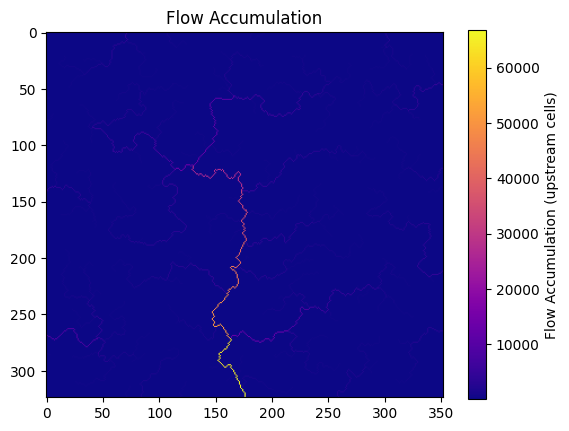

In [13]:
# for each cell, how many other cells drain into it. high value --- river/stream 
# low value --- flat area or hilltop

import rasterio
import matplotlib.pyplot as plt

with rasterio.open("flow_acc.tif") as src:
    acc = src.read(1)

plt.imshow(acc, cmap="plasma", )
plt.colorbar(label="Flow Accumulation (upstream cells)")
plt.title("Flow Accumulation")
plt.show()


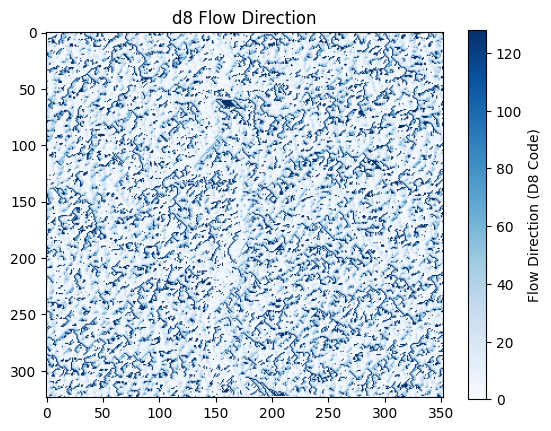

In [14]:
import rasterio
import matplotlib.pyplot as plt

with rasterio.open("flow_dir.tif") as src:
    acc = src.read(1)

plt.imshow(acc, cmap="Blues")
plt.colorbar(label="Flow Direction (D8 Code)")
plt.title("d8 Flow Direction")
plt.show()

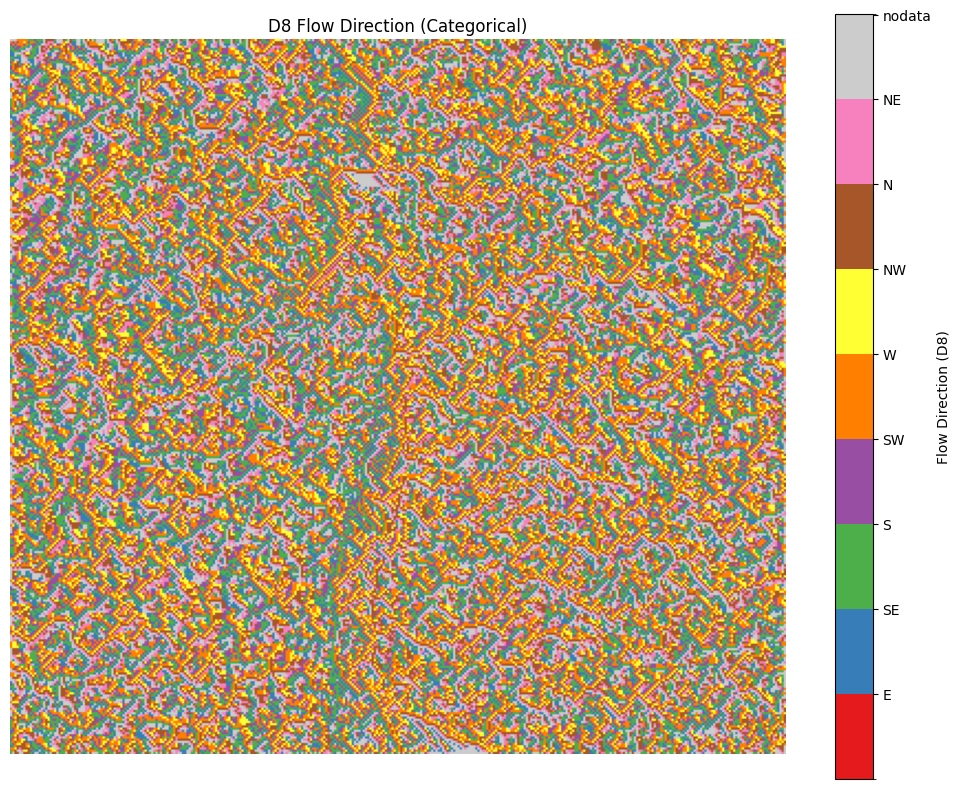

In [15]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm

# D8 codes and their colors
d8_codes = [1, 2, 4, 8, 16, 32, 64, 128]
d8_labels = ['E', 'SE', 'S', 'SW', 'W', 'NW', 'N', 'NE']
colors = [
    "#e41a1c",  # E - red
    "#377eb8",  # SE - blue
    "#4daf4a",  # S - green
    "#984ea3",  # SW - purple
    "#ff7f00",  # W - orange
    "#ffff33",  # NW - yellow
    "#a65628",  # N - brown
    "#f781bf",  # NE - pink
    "#cccccc",  # nodata/other - gray
]
boundaries = [0] + d8_codes + [256]  # 9 boundaries for 8 bins + 1 for nodata

cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries, cmap.N)

with rasterio.open("flow_dir.tif") as src:
    flow_dir = src.read(1)
    # Set nodata/invalid values to 255 for visualization
    mask = ~np.isin(flow_dir, d8_codes)
    flow_dir_vis = flow_dir.copy()
    flow_dir_vis[mask] = 255

plt.figure(figsize=(10, 8))
im = plt.imshow(flow_dir_vis, cmap=cmap, norm=norm)
cbar = plt.colorbar(im, ticks=d8_codes + [255])
cbar.ax.set_yticklabels(d8_labels + ["nodata"])
cbar.set_label("Flow Direction (D8)")

plt.title("D8 Flow Direction (Categorical)")
plt.axis("off")
plt.tight_layout()
plt.show()

In [16]:
import numpy as np
import rasterio

STREAM_THRESHOLD = 3000  # you can increase for “only bigger channels”

with rasterio.open("flow_acc.tif") as src:
    flow_acc = src.read(1)

max_acc = np.nanmax(flow_acc)
print(f"Max flow-accumulation in box = {max_acc:.0f} cells")

if max_acc < STREAM_THRESHOLD:
    print("⚠️ No channel found in this 100 km2 -acre box (flow_acc < threshold).")
    # Stop here: do not proceed to watershed or flood.
else:
    print("✅ Channel(s) detected. Proceeding to watershed delineation…")


Max flow-accumulation in box = 66816 cells
✅ Channel(s) detected. Proceeding to watershed delineation…


.\whitebox_tools.exe --run="ExtractStreams" --wd="e:\Xylem_test" --flow_accum='e:\Xylem_test\flow_acc.tif' --output='e:\Xylem_test\streams.tif' --threshold='3000' -v --compress_rasters=False

*****************************


* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Progress: 46%
Progress: 47%
Progress: 48%
Progress: 49%
Progress: 50%
Progress: 51%
Progress: 52%
Progress: 53%
Progress: 54%
Progress: 55%
Progress: 56%
Progress: 57%
Progress: 58%
Progress: 59%
Progress: 60%
Progress: 61%
Progre

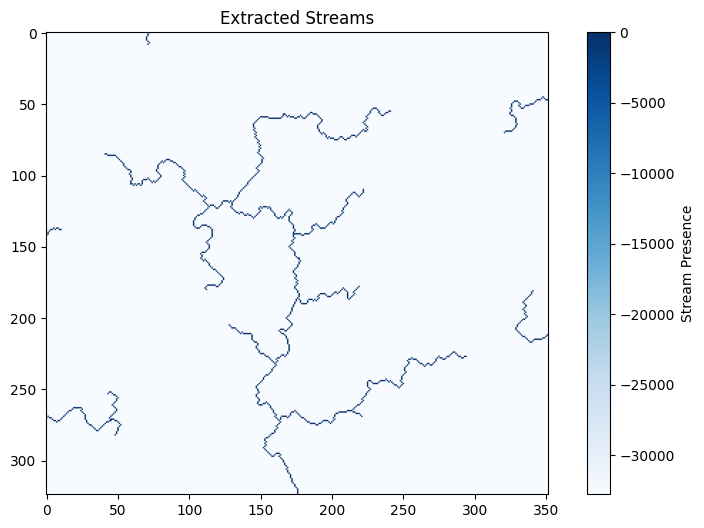

In [17]:
from whitebox import WhiteboxTools
import rasterio
import matplotlib.pyplot as plt

wbt = WhiteboxTools()
wbt.set_working_dir(r"e:\Xylem_test")

flow_acc = r"e:\Xylem_test\flow_acc.tif"
streams = r"e:\Xylem_test\streams.tif"

# Extract streams using a threshold (adjust as needed)
wbt.extract_streams(
    flow_accum=flow_acc,
    output=streams,
    threshold=3000 # Try 500, 1000, or 2000 for different densities
)

# Plot the extracted streams
with rasterio.open(streams) as src:
    streams_data = src.read(1)

plt.figure(figsize=(10, 6))
plt.title("Extracted Streams")
plt.imshow(streams_data, cmap="Blues")
plt.colorbar(label="Stream Presence")
plt.show()


.\whitebox_tools.exe --run="ExtractStreams" --wd="e:\Xylem_test" --flow_accum='e:\Xylem_test\flow_acc.tif' --output='e:\Xylem_test\streams.tif' --threshold='3000' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Progress

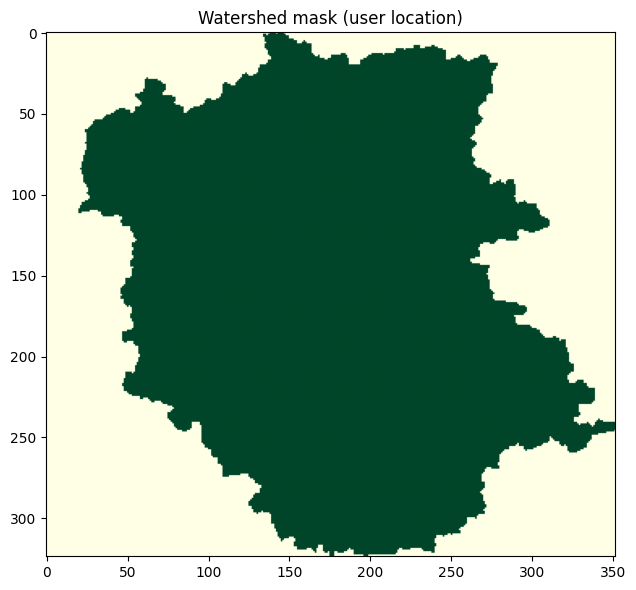

In [18]:
from whitebox import WhiteboxTools
import rasterio
import numpy as np

wbt = WhiteboxTools()
wbt.set_working_dir(r"e:\Xylem_test")


# 1) Extract streams (binary) using our threshold
wbt.extract_streams(
    flow_accum= r"e:\Xylem_test\flow_acc.tif",
    output= r"e:\Xylem_test\streams.tif",
    threshold=STREAM_THRESHOLD
)
print("✔️ Stream network: streams_user.tif")

# 2) Find the row/col of the single "most-accumulation" pixel to use as a pour point
with rasterio.open("flow_acc.tif") as src:
    flow_acc_arr = src.read(1)
    transform = src.transform

# Locate the pixel with maximum flow accumulation
idx_flat = np.nanargmax(flow_acc_arr)
r, c = np.unravel_index(idx_flat, flow_acc_arr.shape)
# Convert r,c to lon/lat:
lon_pp, lat_pp = (
    transform.c + c * transform.a + transform.a/2,
    transform.f + r * transform.e + transform.e/2
)
print(f"Pour point pixel at row {r}, col {c} → lon={lon_pp:.6f}, lat={lat_pp:.6f}")

# 3) Write that pour point to a tiny shapefile
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

gdf = gpd.GeoDataFrame(
    pd.DataFrame({'id':[1]}),
    geometry=[Point(lon_pp, lat_pp)],
    crs="EPSG:4326"
)
gdf.to_file("pour_point.shp")
print("✔️ Pour point shapefile: pour_point.shp")

# 4) Snap the pour point to the stream channel (within, say, 10 pixels)
wbt.snap_pour_points(
    pour_pts="pour_point.shp",
    flow_accum="flow_acc.tif",
    output="snapped_pp.shp",
    snap_dist=10
)
print("✔️ Snapped pour point: snapped_pp.shp")

# 5) Delineate watershed
wbt.watershed(
    d8_pntr="flow_dir.tif",
    pour_pts="snapped_pp.shp",
    output="watershed.tif"
)
print("✔️ Watershed: watershed.tif")

# (Optional) Plot the watershed mask
with rasterio.open("watershed.tif") as src:
    ws_user = src.read(1)
    plt.figure(figsize=(10,6))
    plt.imshow(ws_user, cmap="YlGn")
    plt.title("Watershed mask (user location)")
    plt.tight_layout()
    plt.show()


In [15]:
pip install geopandas --quiet


Note: you may need to restart the kernel to use updated packages.


In [19]:
wbt.strahler_stream_order(
    d8_pntr=r"e:\Xylem_test\flow_dir.tif",
    streams=r"e:\Xylem_test\streams.tif",
    output=r"e:\Xylem_test\strahler.tif"
)


.\whitebox_tools.exe --run="StrahlerStreamOrder" --wd="e:\Xylem_test" --d8_pntr='e:\Xylem_test\flow_dir.tif' --streams='e:\Xylem_test\streams.tif' --output='e:\Xylem_test\strahler.tif' -v --compress_rasters=False



**********************************
* Welcome to StrahlerStreamOrder *
* Powered by WhiteboxTools       *
* www.whiteboxgeo.com            *
**********************************
Reading pointer data...
Reading streams data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Progress: 46%
Progress: 47%
Progress: 48%
Progress: 49%
Progress: 50%
Progress: 51%
Progress: 52%
Progress: 53%
Progress: 54%
Progress: 55%
Pro

0

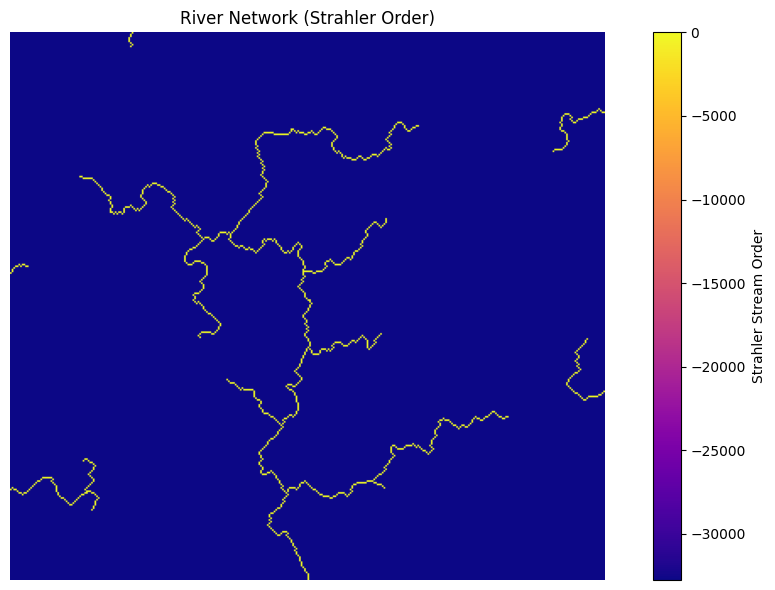

In [20]:
with rasterio.open("strahler.tif") as src:
    strahler = src.read(1)

plt.figure(figsize=(10, 6))
plt.imshow(strahler, cmap="plasma")
plt.colorbar(label="Strahler Stream Order")
plt.title("River Network (Strahler Order)")
plt.axis("off")
plt.tight_layout()
plt.show()


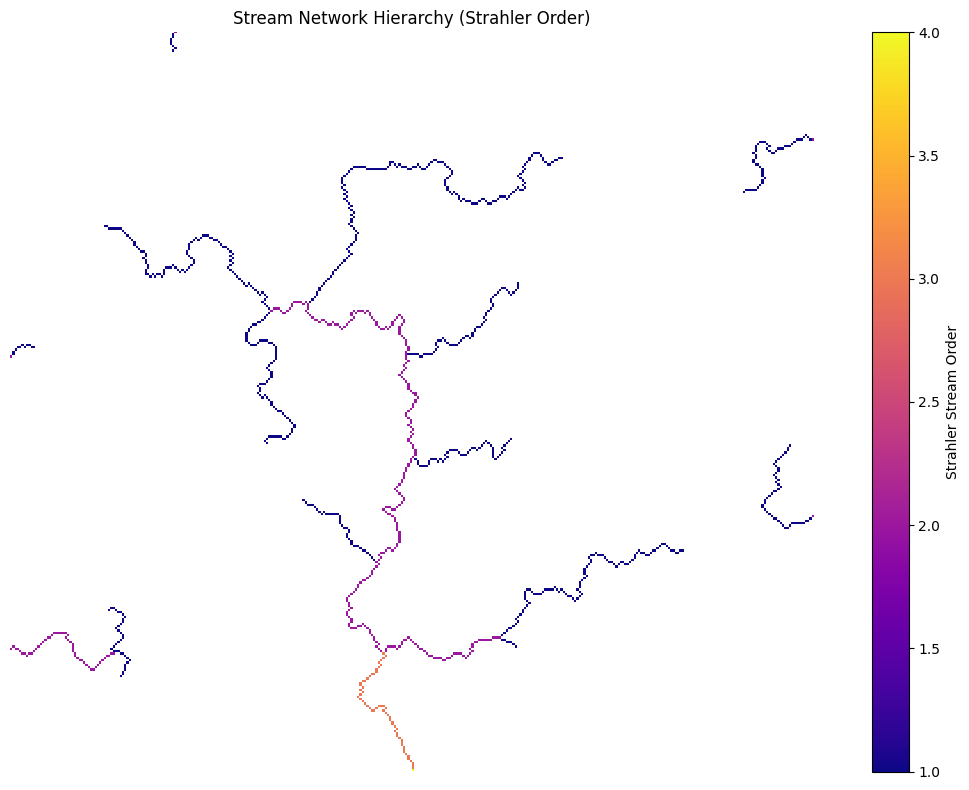

In [21]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

with rasterio.open("strahler.tif") as src:
    strahler = src.read(1)
with rasterio.open("streams.tif") as src:
    streams = src.read(1)

# Mask out non-stream pixels (show only where streams==1)
order_masked = np.where(streams == 1, strahler, np.nan)

plt.figure(figsize=(12, 8))
plt.imshow(order_masked, cmap="plasma", interpolation="none")
plt.colorbar(label="Strahler Stream Order")
plt.title("Stream Network Hierarchy (Strahler Order)")
plt.axis("off")
plt.tight_layout()
plt.show()

In [22]:
pip install networkx rasterio numpy --quiet


Note: you may need to restart the kernel to use updated packages.


In [22]:
import rasterio
import numpy as np
import networkx as nx

# 1. Load flow direction and stream raster
with rasterio.open("flow_dir.tif") as src:
    flow_dir = src.read(1)
    transform = src.transform

with rasterio.open("streams.tif") as src:
    streams = src.read(1)

# 2. Define D8 flow direction codes → row/col offsets
# (matches WhiteboxTools pointer values)
direction_dict = {
    1: (0, 1),     # East
    2: (1, 1),     # SE
    4: (1, 0),     # South
    8: (1, -1),    # SW
    16: (0, -1),   # West
    32: (-1, -1),  # NW
    64: (-1, 0),   # North
    128: (-1, 1)   # NE
}

# 3. Create a directed graph
G = nx.DiGraph()

rows, cols = streams.shape
for r in range(rows):
    for c in range(cols):
        if streams[r, c] == 1:  # only stream pixels
            dir_val = flow_dir[r, c]
            if dir_val in direction_dict:
                dr, dc = direction_dict[dir_val]
                nr, nc = r + dr, c + dc
                if 0 <= nr < rows and 0 <= nc < cols and streams[nr, nc] == 1:
                    G.add_edge((r, c), (nr, nc))  # from current to downstream

print(f"✅ Graph built: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")


✅ Graph built: 7 nodes, 4 edges


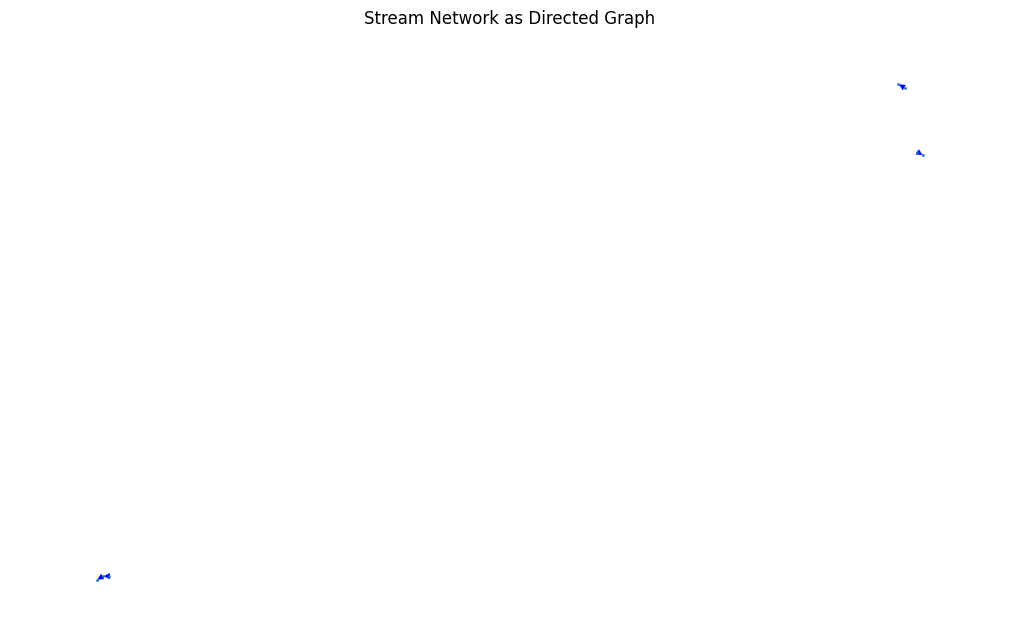

In [23]:
import matplotlib.pyplot as plt
pos = {node: (node[1], -node[0]) for node in G.nodes()}  # X = col, Y = -row
plt.figure(figsize=(10, 6))
nx.draw(G, pos, node_size=1, edge_color="blue", width=0.3)
plt.title("Stream Network as Directed Graph")
plt.axis("off")
plt.show()


In [178]:
pip install scipy --quiet

Note: you may need to restart the kernel to use updated packages.


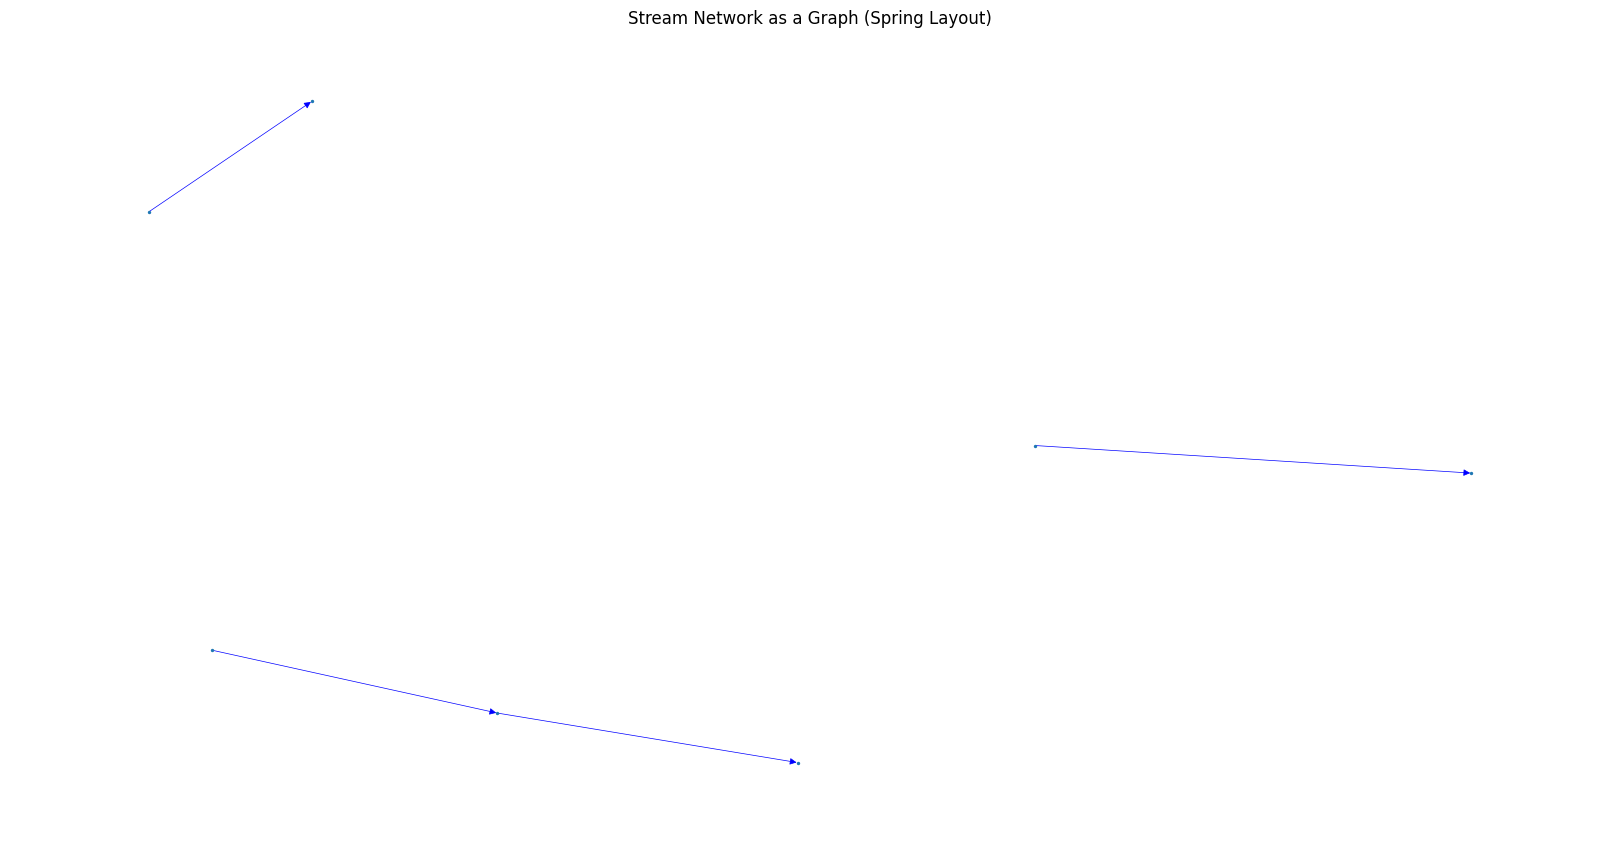

In [24]:
import matplotlib.pyplot as plt
import networkx as nx
plt.figure(figsize=(16, 8))
nx.draw(G, with_labels=False, node_size=2, edge_color="blue", width=0.5)
plt.title("Stream Network as a Graph (Spring Layout)")
plt.axis("off")
plt.show()

In [28]:
pip install awscli --quiet

Note: you may need to restart the kernel to use updated packages.


In [29]:
pip install tqdm --quiet

Note: you may need to restart the kernel to use updated packages.


In [26]:
import geopandas as gpd

s3_url_prefix = "https://esa-worldcover.s3.eu-central-1.amazonaws.com"

# load natural earth low res shapefile
ne = gpd.read_file(r"e:\Xylem_test\ne_110m_admin_0_countries.shp")

# get AOI geometry (Bangladesh in this case)
country = 'Bangladesh'
geom = ne[ne["NAME"] == country].iloc[0].geometry

# load worldcover grid
url = f'{s3_url_prefix}/esa_worldcover_grid.geojson'
grid = gpd.read_file(url)

# get grid tiles intersecting AOI
tiles = grid[grid.intersects(geom)]

# use requests library to download them
import requests
from tqdm.auto import tqdm  # provides a progressbar
from pathlib import Path

year = 2021  # setting this to 2020 will download the v100 product instead

# select version tag, based on the year
version = {2020: 'v100',
           2021: 'v200'}[year]

output_folder = '.'  # use current directory or set a different one to store downloaded files
for tile in tqdm(tiles.ll_tile):
    url = f"{s3_url_prefix}/{version}/{year}/map/ESA_WorldCover_10m_{year}_{version}_{tile}_Map.tif"
    r = requests.get(url, allow_redirects=True)
    out_fn = Path(output_folder) / Path(url).name
    with open(out_fn, 'wb') as f:
        f.write(r.content)

  0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import rasterio
from rasterio.merge import merge
from pathlib import Path

# List of your downloaded land cover tiles
tile_files = list(Path('.').glob("ESA_WorldCover_10m_2021_v200_*_Map.tif"))

# Merge all the tiles into one array
src_files = [rasterio.open(str(f)) for f in tile_files]
mosaic, out_transform = merge(src_files)

# Save the merged raster
out_meta = src_files[0].meta.copy()
out_meta.update({
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_transform
})

with rasterio.open("merged_landcover.tif", "w", **out_meta) as dest:
    dest.write(mosaic)
print("✅ Merged land cover saved as: merged_landcover.tif")



In [26]:
import rasterio

# 1) Open watershed as a raster to get its bounds and transform
with rasterio.open("watershed.tif") as src_ws:
    ws = src_ws.read(1)           # this is a small array already
    ws_transform = src_ws.transform
    ws_crs = src_ws.crs
    # Geographic bounds of the watershed (minx, miny, maxx, maxy)
    ws_bounds = src_ws.bounds     # in the same CRS as the raster (EPSG:4326 likely)

print("Watershed bounds (lon/lat):", ws_bounds)


Watershed bounds (lon/lat): BoundingBox(left=91.28763888892485, bottom=22.786527777772854, right=91.38541666670264, top=22.876527777772864)


In [27]:
import rasterio
from rasterio.windows import from_bounds
from rasterio.enums import Resampling
import numpy as np

# 2) Path to your full ESA WorldCover tile
esa_path = "merged_landcover.tif"

# 3) Open the ESA tile, compute the window that covers the watershed bounds
with rasterio.open(esa_path) as src_lc:
    # Ensure the ESA tile’s CRS matches your watershed’s CRS; likely both are EPSG:4326.
    if src_lc.crs != ws_crs:
        raise RuntimeError("CRS mismatch: reproject waterfall first.")
    
    # Compute the row/col window that covers the watershed bounds
    window = from_bounds(
        ws_bounds.left,
        ws_bounds.bottom,
        ws_bounds.right,
        ws_bounds.top,
        transform=src_lc.transform
    )
    # Round out to integer row/col indices
    window = window.round_offsets().round_shape()
    
    # Read just that window into memory
    lc_window = src_lc.read(1, window=window)
    lc_window_transform = src_lc.window_transform(window)
    lc_meta = src_lc.meta.copy()

# 4) Update metadata to reflect that lc_window is smaller
lc_meta.update({
    "height": lc_window.shape[0],
    "width": lc_window.shape[1],
    "transform": lc_window_transform
})
print("📏 Landcover window shape:", lc_window.shape)


📏 Landcover window shape: (1080, 1173)


In [28]:
import numpy as np

# 5) Define ESA class → runoff coefficient lookup
c_lookup = {
    10: 0.10,  # Tree cover
    20: 0.15,  # Shrubland
    30: 0.20,  # Grassland
    40: 0.30,  # Cropland
    50: 0.85,  # Urban
    60: 0.40,  # Bare / sparse
    70: 0.05,  # Snow / ice
    80: 0.05,  # Water
    90: 0.25,  # Wetlands
    95: 0.10,  # Mangroves
    100: 0.20  # Moss & lichen
}

# 6) Create a small C array the same shape as lc_window
C_window = np.full(lc_window.shape, np.nan, dtype=np.float32)

# 7) Fill C_window based on lookup
for cls_val, c_val in c_lookup.items():
    mask = (lc_window == cls_val)
    C_window[mask] = c_val

# Any pixel in lc_window not in our c_lookup stays NaN (e.g. no-data or unexpected values)


In [29]:
import numpy as np
from rasterio.warp import reproject, Resampling

# Prepare an empty array to hold the resampled mask
ws_resampled = np.zeros(lc_window.shape, dtype=np.uint8)

# Reproject (resample) the watershed mask into this new array
reproject(
    source=ws,                           # full-resolution watershed
    destination=ws_resampled,            # this will get high‐res mask
    src_transform=ws_transform,
    dst_transform=lc_window_transform,
    src_crs=ws_crs,
    dst_crs=ws_crs,
    resampling=Resampling.nearest        # nearest neighbor (keeps 1’s as 1’s)
)

print("Shape of resampled watershed mask:", ws_resampled.shape)


Shape of resampled watershed mask: (1080, 1173)


In [30]:
# Define your ESA WorldCover → C lookup
c_lookup = {
    10: 0.10,   # Tree cover
    20: 0.15,   # Shrubland
    30: 0.20,   # Grassland
    40: 0.30,   # Cropland
    50: 0.85,   # Urban
    60: 0.40,   # Bare / sparse
    70: 0.05,   # Snow / ice
    80: 0.05,   # Water
    90: 0.25,   # Wetlands
    95: 0.10,   # Mangroves
    100: 0.20   # Moss & lichen
}

# Create C_window with the same shape as lc_window
C_window = np.full_like(lc_window, np.nan, dtype=np.float32)

for cls_val, c_val in c_lookup.items():
    C_window[lc_window == cls_val] = c_val

# Any pixel not in lookup will remain NaN


In [31]:
C_inside = np.where(ws_resampled == 1, C_window, np.nan)

# Compute mean C inside watershed
mean_C = np.nanmean(C_inside)
print(f"🔹 Mean C inside watershed = {mean_C:.3f}")


🔹 Mean C inside watershed = 0.212


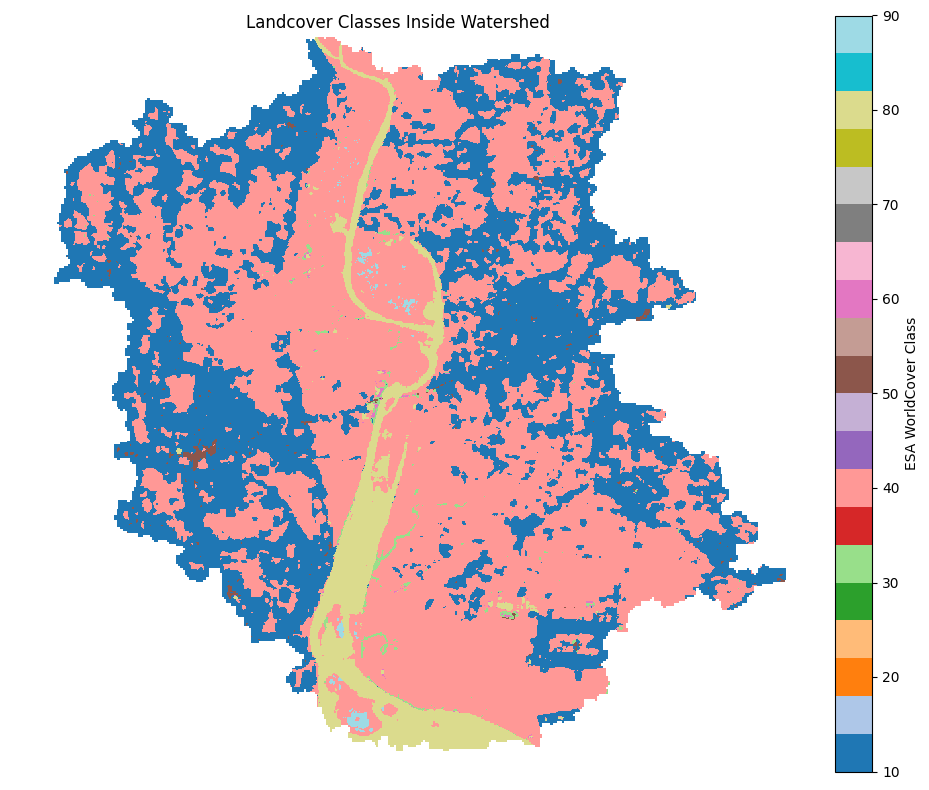

✅ Saved: landcover_in_watershed.tif


In [32]:
# Show only the watershed area from merged_landcover.tif
import matplotlib.pyplot as plt
import numpy as np
import rasterio

# Mask the landcover window with the watershed mask
lc_ws = np.where(ws_resampled == 1, lc_window, np.nan)

plt.figure(figsize=(10, 8))
plt.imshow(lc_ws, cmap="tab20", interpolation="none")
plt.title("Landcover Classes Inside Watershed")
plt.axis("off")
plt.colorbar(label="ESA WorldCover Class")
plt.tight_layout()
plt.show()

# Save the masked landcover as a new GeoTIFF
lc_meta.update({
    "dtype": "float32",
    "nodata": np.nan
})
with rasterio.open("landcover_in_watershed.tif", "w", **lc_meta) as dst:
    dst.write(lc_ws, 1)

print("✅ Saved: landcover_in_watershed.tif")

In [33]:
import rasterio

out_meta = lc_meta.copy()
out_meta.update({
    "dtype": "float32",
    "count": 1,
    "nodata": np.nan
})

with rasterio.open("C_inside_watershed.tif", "w", **out_meta) as dst:
    dst.write(C_inside, 1)

print("✅ Saved: C_inside_watershed.tif")


✅ Saved: C_inside_watershed.tif


In [34]:
# Count pixels = 1 inside watershed in the high‐res mask
import numpy as np
num_pixels_inside = np.sum(ws_resampled == 1)

# Each pixel ≈ 10 m × 10 m = 100 m²
pixel_area_m2 = 10 * 10
A_m2 = num_pixels_inside * pixel_area_m2
A_km2 = A_m2 / 1e6
A_acres = A_m2 / 4046.86  # convert m² to acres

print(f"🔹 Watershed area ≈ {A_km2:.3f} km² ({A_m2:.0f} m²)")
print(f"🔹 Watershed area ≈ {A_acres:.3f} acres")


🔹 Watershed area ≈ 74.237 km² (74236800 m²)
🔹 Watershed area ≈ 18344.297 acres


In [35]:
# Given values:
i_inch_hour = 5         # chosen intensity (inches/hour) here we will input rainfall data from turjo's model


# Rational method: Q = C * i * A
Q_feet3_s = mean_C * i_inch_hour * A_acres
print(f"🔹 Peak discharge Q ≈ {Q_feet3_s:.2f} feet3/s")


🔹 Peak discharge Q ≈ 19454.90 feet3/s


In [36]:
import rasterio
import numpy as np


# Replace 'worldcover.tif' with your ESA WorldCover or water mask file
with rasterio.open('landcover_in_watershed.tif') as src:
    worldcover = src.read(1)  # assume single band, water class = 80
    water_pixels = np.count_nonzero(worldcover == 80)
    total_pixels = worldcover.size

river_fraction = water_pixels / total_pixels
print (river_fraction)

A_feet2 = A_acres * 43560  # convert acres to square feet
flood_h = 150 # the time for which the rainfall will last (in hours)

elevation_feet = ((Q_feet3_s/ river_fraction) * (3600/A_feet2)*flood_h)   # in feet
elevation_meters = elevation_feet * 0.3048  # convert feet to meters

print(f"🔹 Estimated river surface area increase: {elevation_feet:.2f} feet")
print(f"🔹 Estimated river surface area increase: {elevation_meters:.2f} meters")



0.035852988538410534
🔹 Estimated river surface area increase: 366.70 feet
🔹 Estimated river surface area increase: 111.77 meters


In [37]:
import rasterio

with rasterio.open('filled_dem.tif') as dem:
    print("CRS:", dem.crs)  # Coordinate system
    print("Bounds:", dem.bounds)  # Geographic extent
    print("Width (pixels):", dem.width)
    print("Height (pixels):", dem.height)
    print("Resolution:", dem.res)  # (xres, yres) — pixel size
    print("Data Type:", dem.dtypes[0])  # Usually float32
    print("Driver:", dem.driver)  # Usually 'GTiff'
    print("NoData Value:", dem.nodata)
    print("Transform:", dem.transform)  # Affine transform


CRS: EPSG:4326
Bounds: BoundingBox(left=91.28763888892485, bottom=22.786527777772854, right=91.38541666670264, top=22.876527777772864)
Width (pixels): 352
Height (pixels): 324
Resolution: (0.0002777777777778146, 0.0002777777777778146)
Data Type: float64
Driver: GTiff
NoData Value: -32768.0
Transform: | 0.00, 0.00, 91.29|
| 0.00,-0.00, 22.88|
| 0.00, 0.00, 1.00|


Flood depth and inundation mask saved.


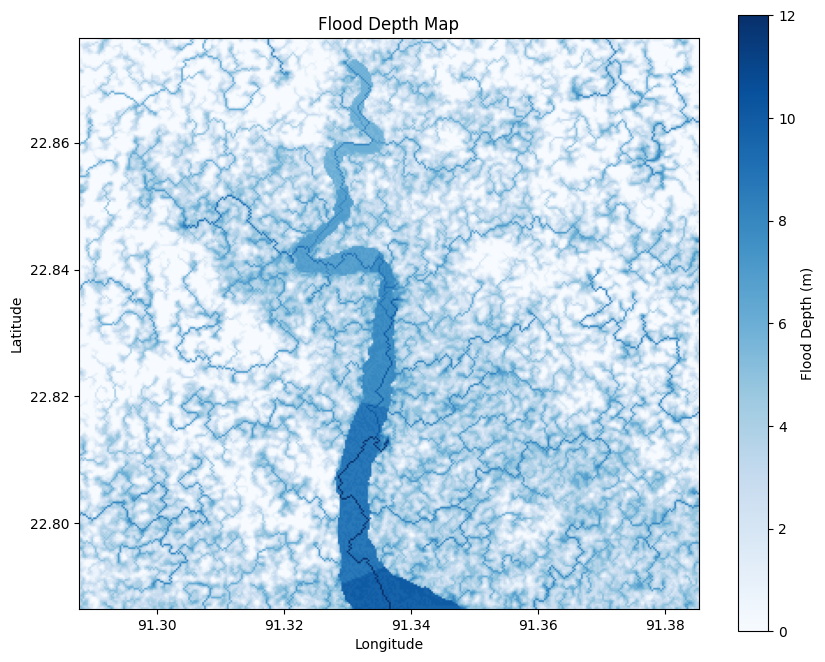

In [38]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt

flood_h = 150
# Load the DEM
with rasterio.open("filled_dem.tif") as src:
    dem = src.read(1)  # Elevation data
    transform = src.transform
    profile = src.profile

# Define the total flood volume (in cubic meters)
# Use the previously calculated Q_feet3_s and flood_h
V_total_m3 = Q_feet3_s * flood_h * 3600 * 0.0283168  # Convert ft³ to m³

# Create a water depth array (same shape as the DEM)
water_depth = np.zeros_like(dem, dtype=np.float32)

# Mask invalid DEM values (e.g., nodata)
nodata = src.nodata if src.nodata is not None else -9999
dem = np.where(dem == nodata, np.nan, dem)

# Iteratively "fill" the DEM with water
remaining_volume = V_total_m3
cell_area_m2 = 30 * 30 # DEM from SRTMGL1 is 30m resolution, so each cell is 30m x 30m = 900 m²
while remaining_volume > 0:
    # Find the lowest elevation that is not yet flooded
    min_elevation = np.nanmin(dem + water_depth)
    
    # Calculate the number of cells at this elevation
    flood_cells = (dem + water_depth == min_elevation)
    num_flood_cells = np.sum(flood_cells)
    
    # Calculate the volume required to raise these cells by 1 meter
    volume_per_meter = num_flood_cells * cell_area_m2
    
    # Determine how much water can be added to these cells
    if remaining_volume >= volume_per_meter:
        # Add 1 meter of water to these cells
        water_depth[flood_cells] += 1
        remaining_volume -= volume_per_meter
    else:
        # Add the remaining water evenly to these cells
        water_depth[flood_cells] += remaining_volume / volume_per_meter
        remaining_volume = 0

# Calculate the final flood depth
flood_depth = water_depth

# Create a flood inundation mask (1 = flooded, 0 = not flooded)
inundation_mask = (flood_depth > 0).astype(np.uint8)

# Save the flood depth and inundation mask as GeoTIFFs
flood_depth_profile = profile.copy()
flood_depth_profile.update({
    "dtype": "float32",
    "count": 1,
    "nodata": np.nan
})

with rasterio.open("flood_depth.tif", "w", **flood_depth_profile) as dst:
    dst.write(flood_depth, 1)

inundation_profile = profile.copy()
inundation_profile.update({
    "dtype": "uint8",
    "count": 1,
    "nodata": 0
})

with rasterio.open("flood_inundation_mask.tif", "w", **inundation_profile) as dst:
    dst.write(inundation_mask, 1)

print("Flood depth and inundation mask saved.")

# Visualize the flood depth
plt.figure(figsize=(10, 8))
plt.imshow(flood_depth, cmap="Blues", extent=(transform[2], transform[2] + dem.shape[1] * transform[0],
                                              transform[5] + dem.shape[0] * transform[4], transform[5]))
plt.colorbar(label="Flood Depth (m)")
plt.title("Flood Depth Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [39]:
# Calculate the total flooded area (in square meters and square kilometers)
pixel_area_m2 = 30 * 30  # 30 x 30 meters reslution DEM
flooded_area_m2 = np.sum(inundation_mask) * pixel_area_m2
flooded_area_km2 = flooded_area_m2 / 1e6  # Convert to square kilometers

# Calculate the total flooded volume (in cubic meters)
flooded_volume_m3 = np.nansum(flood_depth * pixel_area_m2)

print(f"🔹 Total Flooded Area: {flooded_area_km2:.2f} km²")
print(f"🔹 Total Flooded Volume: {flooded_volume_m3:.2f} m³")

🔹 Total Flooded Area: 87.15 km²
🔹 Total Flooded Volume: 297486304.00 m³


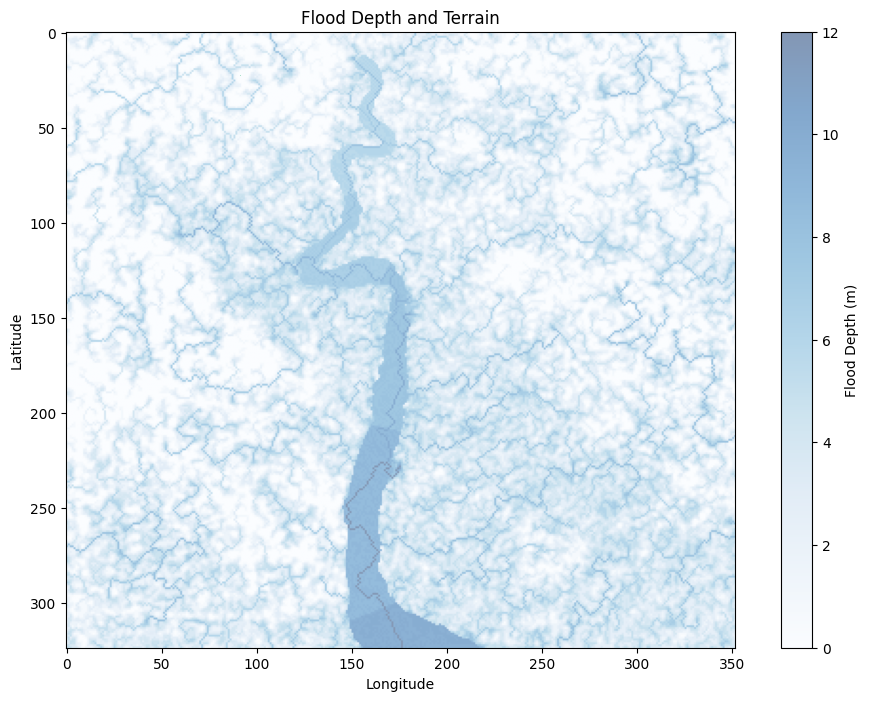

In [40]:
plt.figure(figsize=(12, 8))
plt.imshow(dem, cmap="terrain", extent=(transform[2], transform[2] + dem.shape[1] * transform[0],
                                        transform[5] + dem.shape[0] * transform[4], transform[5]))
plt.imshow(flood_depth, cmap="Blues", alpha=0.5)  # Overlay flood depth
plt.colorbar(label="Flood Depth (m)")
plt.title("Flood Depth and Terrain")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [41]:
from scipy.ndimage import zoom

scale_y = dem.shape[0] / flood_depth.shape[0]
scale_x = dem.shape[1] / flood_depth.shape[1]
flood_depth_resized = zoom(flood_depth, (scale_y, scale_x), order=1)  # Bilinear interpolation

print("Resized flood depth shape:", flood_depth_resized.shape)

Resized flood depth shape: (324, 352)


In [42]:
flood_depth_flattened = flood_depth_resized.ravel()

In [43]:
grid["Flood Depth"] = np.nan_to_num(flood_depth_flattened, nan=0)
flooded_elevation = np.where(flood_depth_resized > 0, dem + flood_depth_resized, np.nan)
grid["Flooded Elevation"] = np.nan_to_num(flooded_elevation.ravel(), nan=dem.ravel())

In [44]:
import pyvista as pv
import numpy as np
import rasterio
from scipy.ndimage import zoom

# Load the DEM
with rasterio.open("filled_dem.tif") as src:
    dem = src.read(1)  # Elevation data
    transform = src.transform

# Load the flood depth
with rasterio.open("flood_depth.tif") as src:
    flood_depth = src.read(1)  # Flood depth data

# Mask invalid DEM values (e.g., nodata)
nodata = src.nodata if src.nodata is not None else -9999
dem = np.where(dem == nodata, np.nan, dem)

# Ensure flood depth matches DEM dimensions
if flood_depth.shape != dem.shape:
    scale_y = dem.shape[0] / flood_depth.shape[0]
    scale_x = dem.shape[1] / flood_depth.shape[1]
    flood_depth_resized = zoom(flood_depth, (scale_y, scale_x), order=1)  # Resample to match DEM
else:
    flood_depth_resized = flood_depth

rows, cols = dem_data.shape
x = np.arange(cols)
y = np.arange(rows)
x, y = np.meshgrid(x, y)
z = dem_data  # Elevation data


# Create a PyVista grid
grid = pv.StructuredGrid(x, y, dem)

# Flatten scalars to match the number of points in the grid
flood_depth_flattened = flood_depth_resized.ravel()
flooded_elevation = np.where(flood_depth_resized > 0, dem + flood_depth_resized, np.nan)

# Add the flood depth and flooded elevation as scalar fields
grid["Flood Depth"] = np.nan_to_num(flood_depth_flattened, nan=0)
grid["Flooded Elevation"] = np.nan_to_num(flooded_elevation.ravel(), nan=dem.ravel())

# Create a PyVista plotter
plotter = pv.Plotter()

# Add the terrain surface
plotter.add_mesh(grid, scalars="Flooded Elevation", cmap="terrain", show_edges=False, opacity=0.8)

# Highlight flooded areas
flood_mask = flood_depth_resized > 0
flood_points = np.column_stack((x[flood_mask], y[flood_mask], flooded_elevation[flood_mask]))
flood_cloud = pv.PolyData(flood_points)
plotter.add_mesh(flood_cloud, color="blue", point_size=5, render_points_as_spheres=True, label="Flooded Areas")

# Add legend and labels
plotter.add_legend()
plotter.add_axes()
plotter.show_grid()
plotter.set_background("white")

# Show the interactive plot
plotter.show()

e:\Xylem_test\.venv\Lib\site-packages\pyvista\core\utilities\points.py:77: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


Widget(value='<iframe src="http://localhost:56988/index.html?ui=P_0x1d498aad760_3&reconnect=auto" class="pyvis…